# Neural Network Models

First we need to load all the packages necessary for this notebook. In order to install the packages run pip install requirements.txt

In [93]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import random
from tqdm import tqdm
import sys

Next we get the data using the environment variable ```RESEARCH_DATA_PATH``` which should direct to the data folder of this project

In [94]:
DATA_PATH = os.environ.get("RESEARCH_DATA_PATH")

In [95]:
#MONTHLY DATA
X_mef_m = pd.read_csv(f'{DATA_PATH}/processed/mef_monthly_data_processed.csv')
X_mai_m = pd.read_csv(f'{DATA_PATH}/processed/mai_monthly_data_processed.csv')
y_mkt_m = pd.read_csv(f'{DATA_PATH}/processed/mkt_monthly_data_processed.csv')

X_mef_m['date'] = pd.to_datetime(X_mef_m['date'])
X_mai_m['date'] = pd.to_datetime(X_mai_m['date'])
y_mkt_m['date'] = pd.to_datetime(y_mkt_m['date'])

# Drop the 'date' column from each dataset
X_mef_m = X_mef_m.drop('date', axis=1)
X_mai_m = X_mai_m.drop('date', axis=1)
y_mkt_m = y_mkt_m.drop('date', axis=1)

X_mef_m = X_mef_m.values
X_mai_m = X_mai_m.values
y_mkt_m = y_mkt_m.values

#DAILY DATA
X_mef_d = pd.read_csv(f'{DATA_PATH}/processed/mef_daily_data_processed.csv')
X_mai_d = pd.read_csv(f'{DATA_PATH}/processed/mai_daily_data_processed.csv')
y_mkt_d = pd.read_csv(f'{DATA_PATH}/processed/mkt_daily_data_processed.csv')

X_mef_d['date'] = pd.to_datetime(X_mef_d['date'])
X_mai_d['date'] = pd.to_datetime(X_mai_d['date'])
y_mkt_d['date'] = pd.to_datetime(y_mkt_d['date'])

# Drop the 'date' column from each dataset
X_mef_d = X_mef_d.drop('date', axis=1)
X_mai_d = X_mai_d.drop('date', axis=1)
y_mkt_d = y_mkt_d.drop('date', axis=1)

X_mef_d = X_mef_d.values
X_mai_d = X_mai_d.values
y_mkt_d = y_mkt_d.values

Now we define functions for train-test split, the network architecture and training of the model (seperately for MEF and MAI datasets) and to test the trained models.

In [96]:
# Function: split data into training and test set based on the random state
def split_data(X, y, test_size, random_state):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=random_state)
    return X_train, y_train, X_test, y_test

In [101]:
# Function: build the neural network model for MAI data

def train_neural_network_MAI(X, y):
    """
    Parameters:
    - X: MAI features
    - y: Target variable

    Returns:
    - Trained model
    - Model training history
    """

    # the best number of layers, dropout layers, the best number of units of a layer have been selected
    model = keras.Sequential([
    layers.Dense(64, activation=keras.layers.ELU(),input_dim=8),
    Dropout(0.3),
    layers.Dense(32, activation=keras.layers.ELU()),
    Dropout(0.5),
    layers.Dense(1)  # Output layer with 1 neuron for numerical output
    ])

    # Compile the model
    # the best optimizer and learning rate have been selected
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mae'])

    # Train the model
    # the best number of epochs and batch_size have been selected
    epochs = 10  # Define the number of epochs

    # Suppress the verbose output of model.fit()
    history = model.fit(X, y, epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)

    # Custom progress bar
    with tqdm(total=epochs, file=sys.stdout, desc="Training Progress", bar_format='{l_bar}{bar} {n_fmt}/{total_fmt}') as pbar:
        for epoch in range(epochs):
            # Insert any per-epoch logic or checks if necessary
            pbar.update(1)

    mse_values = history.history['loss']
    mse_values_val = history.history['val_loss']

    avg_RMSE_train = np.mean([mse_value ** 0.5 for mse_value in mse_values])
    avg_RMSE_test = np.mean([mse_value_val ** 0.5 for mse_value_val in mse_values_val])

    return model, history, avg_RMSE_train, avg_RMSE_test

In [102]:
# Function: build the neural network model for MEF data

def train_neural_network_MEF(X, y):
    """
    Parameters:
    - X: MEF features
    - y: Target variable

    Returns:
    - Trained model
    - Model training history
    """

    # the best number of layers, dropout layers, the best number of units of a layer have been selected
    model = keras.Sequential([
    layers.Dense(64, activation=keras.layers.ELU(),input_dim=14),
    Dropout(0.3),
    layers.Dense(32, activation=keras.layers.ELU()),
    Dropout(0.5),
    layers.Dense(1)  # Output layer with 1 neuron for numerical output
    ])

    # Compile the model
    # the best optimizer and learning rate have been selected
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mae'])
    
    epochs = 10  # Define the number of epochs
    
    # Train the model
    # the best number of epochs and batch_size have been selected
    history = model.fit(X, y, epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)

    # Custom progress bar
    with tqdm(total=epochs, file=sys.stdout, desc="Training Progress", bar_format='{l_bar}{bar} {n_fmt}/{total_fmt}') as pbar:
        for epoch in range(epochs):
            # Insert any per-epoch logic or checks if necessary
            pbar.update(1)
    
    mse_values = history.history['loss']
    mse_values_val = history.history['val_loss']

    avg_RMSE_train = np.mean([mse_value ** 0.5 for mse_value in mse_values])
    avg_RMSE_test = np.mean([mse_value_val ** 0.5 for mse_value_val in mse_values_val])

    return model, history, avg_RMSE_train, avg_RMSE_test

In [103]:
#Function: evaluate the performance of the model and show the values in plot
def test_model(model, X_test, y_test):
    """
    Test a trained model and calculate regression metrics.

    Parameters:
    - model: Trained model
    - X_test: Testing features
    - y_test: True values for testing

    Returns:
    - Mean Squared Error (MSE)
    - Mean Absolute Error (MAE)
    - R-squared (R2) score
    """

    # Make y_pred using the trained model
    y_pred = model.predict(X_test)

    # Calculate regression metrics
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)

    # Plot predicted values and true values

    new_y_test = [value for index, value in enumerate(y_test)]
    plt.plot(new_y_test, label='True',color='blue')
    plt.plot(y_pred, label='Prediction',color='red')

    plt.xlabel('Index')
    plt.ylabel('y values')
    plt.title('True vs Pred')

    plt.legend()

    plt.show()

    return MSE, MAE, R2

## Neural Networks with monthly data

As a first approach, we will try to train the Neural Networks using the datasets with monthly data. However we do not expect these models to perform efficiently due to the small size of the datasets (408 points), which is not sufficient for the complexity of a neural network.

In order to achieve more robust results, we will train the networks 10 times over different train-test splits and report the average RMSE.

We start with the MAI data.

Training Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 52.893577139208126 , average validation RMSE is 61.34126501375825
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


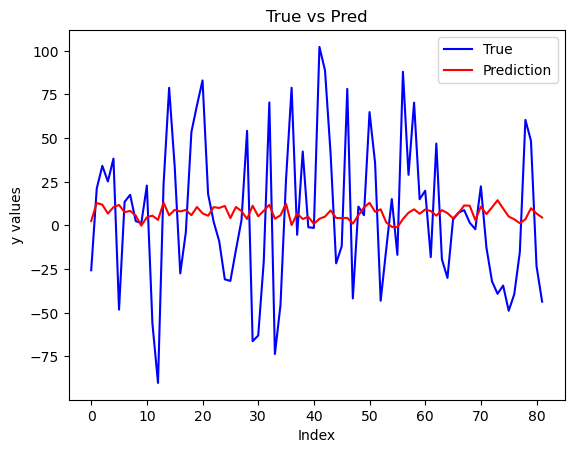

RMSE: 42.154575312126134, MAE: 33.735291671768195, R2: -0.00020954894252755984
Training Iterations:  10%|█         | 1/10 [00:02<00:19,  2.18s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 51.38792362052226 , average validation RMSE is 41.79983238359528
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


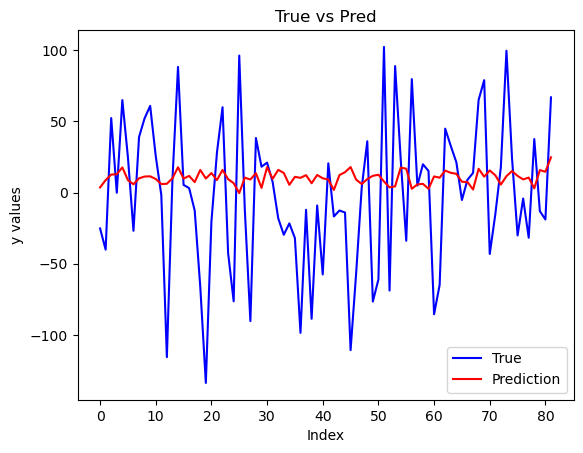

RMSE: 53.912076841921035, MAE: 42.253327454526236, R2: -0.061086197121442254
Training Iterations:  20%|██        | 2/10 [00:04<00:17,  2.14s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 46.47047427339829 , average validation RMSE is 53.39831481291297
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


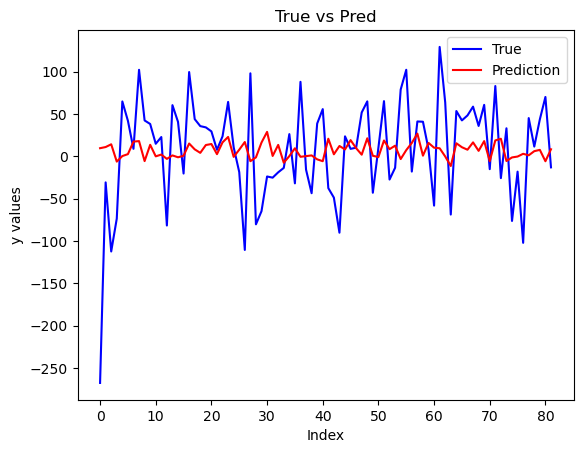

RMSE: 62.30256851876978, MAE: 48.396442962219794, R2: -0.011092001174596966
Training Iterations:  30%|███       | 3/10 [00:06<00:15,  2.19s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 52.25786919890395 , average validation RMSE is 43.95294909042613
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


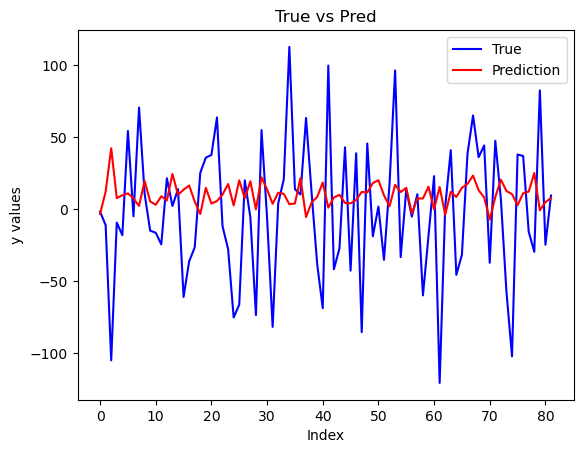

RMSE: 51.21492571168339, MAE: 40.516417209411486, R2: -0.15922859952569013
Training Iterations:  40%|████      | 4/10 [00:09<00:13,  2.33s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 54.537890311410465 , average validation RMSE is 42.000270955386284
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


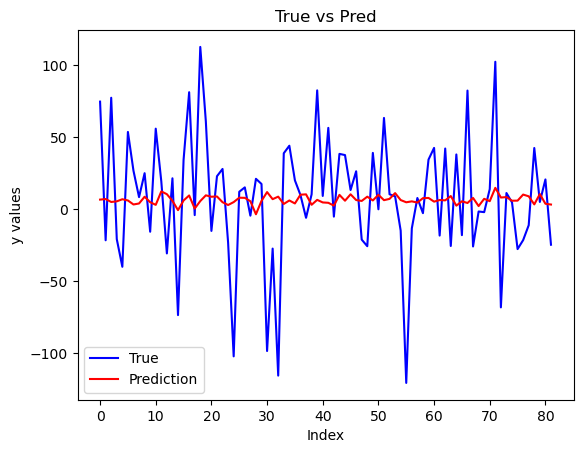

RMSE: 44.22428555199341, MAE: 32.95623241803518, R2: -0.006880265733279822
Training Iterations:  50%|█████     | 5/10 [00:11<00:11,  2.37s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 50.14833108823312 , average validation RMSE is 48.572619015203585
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


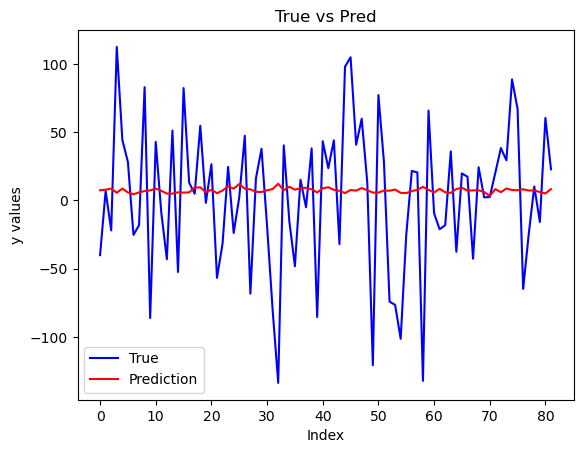

RMSE: 53.72101404524282, MAE: 42.16950238333408, R2: -0.015805106004268765
Training Iterations:  60%|██████    | 6/10 [00:13<00:09,  2.36s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 50.968130561574476 , average validation RMSE is 55.170863712464765
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


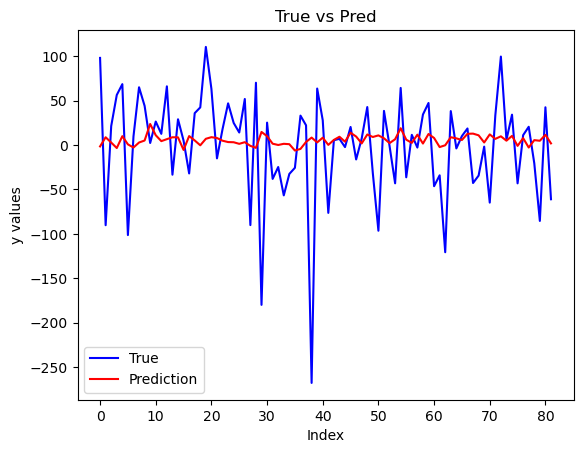

RMSE: 60.54241846153563, MAE: 43.28795796630835, R2: -0.02438597965179068
Training Iterations:  70%|███████   | 7/10 [00:16<00:07,  2.34s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 49.22278025481059 , average validation RMSE is 52.61361001030218
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


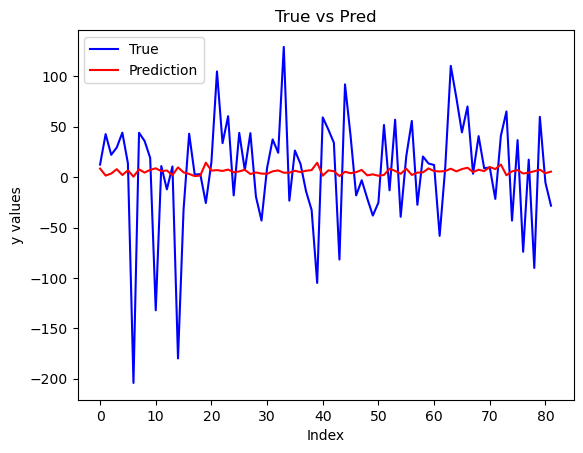

RMSE: 55.723942080025644, MAE: 40.01750416096113, R2: -0.003864512224935668
Training Iterations:  80%|████████  | 8/10 [00:18<00:04,  2.30s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 50.172139597191745 , average validation RMSE is 40.21638662620694
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


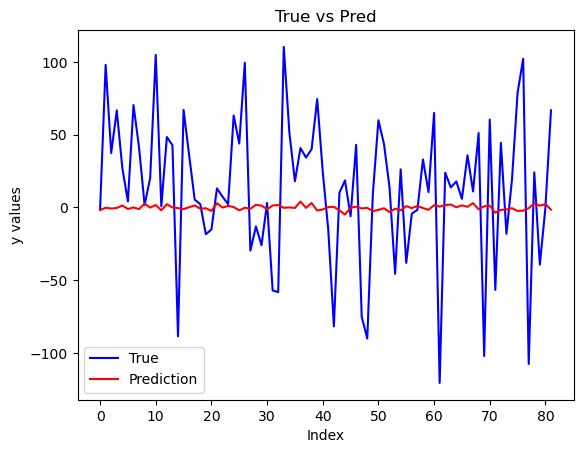

RMSE: 51.48478203788436, MAE: 40.40838399467468, R2: -0.0766962553693662
Training Iterations:  90%|█████████ | 9/10 [00:20<00:02,  2.28s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 48.84444032776336 , average validation RMSE is 42.37497072748655
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


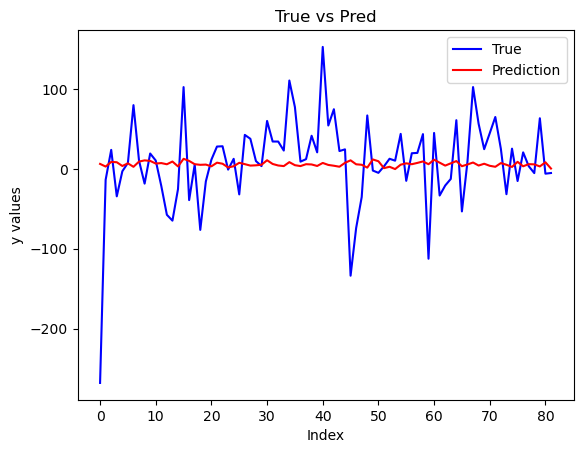

RMSE: 55.68572211413055, MAE: 37.65738638619193, R2: -0.008950438300606933
Training Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.30s/it]
 
 
The average test RMSE over 10 iterations for MAI monthly data is: 53.09663106753128
 
 


In [104]:
# Test the performance of the model on 10 different random train-test splits of MAI monthly data, and report the average RMSE.
list_RMSE_train_train=[]
list_RMSE_train_val=[]
list_RMSE=[]

np.random.seed(11)
random.seed(11)
tf.random.set_seed(11)


# Use tqdm for the outer loop to track progress of iterations
for i in tqdm(range(10), desc="Training Iterations", file=sys.stdout):
    # Generate training and test data sets
    X_train, y_train, X_test, y_test = split_data(X_mai_m, y_mkt_m, 0.2, i)

    # Train the model
    trained_model, training_history, avg_RMSE_train, avg_RMSE_test = train_neural_network_MAI(X_train, y_train)
    print('During training of this NN model, average training RMSE is', avg_RMSE_train, ', average validation RMSE is', avg_RMSE_test)
    list_RMSE_train_train.append(avg_RMSE_train)
    list_RMSE_train_val.append(avg_RMSE_test)

    # Evaluate the model
    MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
    print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')
    list_RMSE.append(MSE**(1/2))

# Calculate and print average RMSE
avg_RMSE = np.mean(list_RMSE)
print(' ')
print(' ')
print('The average test RMSE over 10 iterations for MAI monthly data is:', avg_RMSE)
print(' ')
print(' ')

Text(0.5, 1.0, 'Distribution of RMSE over Iterations (MAI monthly training data)')

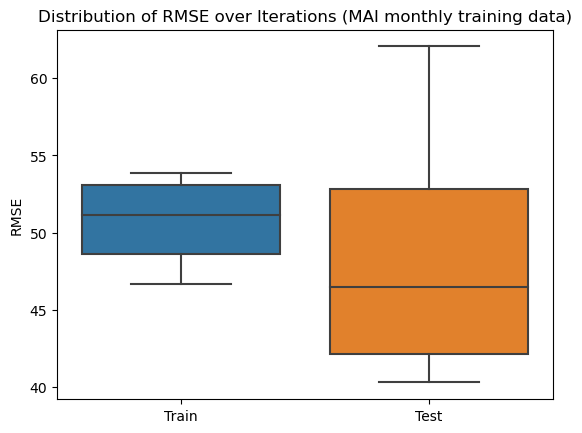

In [81]:
sns.boxplot(data=[list_RMSE_train_train, list_RMSE_train_val])
plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('RMSE')
plt.title('Distribution of RMSE over Iterations (MAI monthly training data)')

The standard variation of RMSE is 6.08495158580444


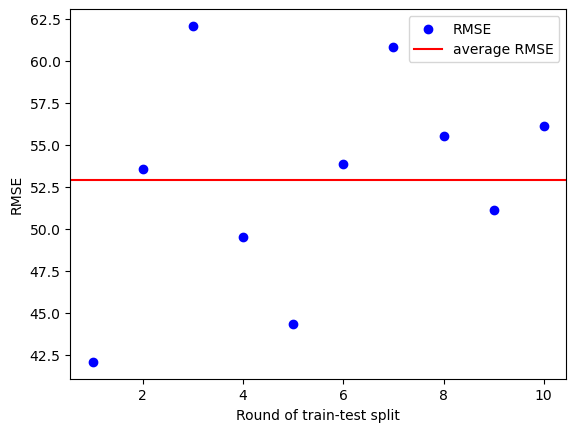

In [82]:
# Calculate the standard variation of RMSE
print('The standard variation of RMSE is', np.std(list_RMSE))
# Plot the RMSE of each round of random split
plt.scatter(y=list_RMSE,x=range(1,11),label='RMSE',color='blue')
plt.axhline(y=avg_RMSE, label='average RMSE',linestyle='-',color='red')

plt.xlabel('Round of train-test split')
plt.ylabel('RMSE')
#plt.title('RMSE of each round of random split, NN on MAI monthly')

plt.legend()

plt.show()

Now we do the same with the MEF monthly data.

Training Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 50.3559390207257 , average validation RMSE is 61.21908751495408
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


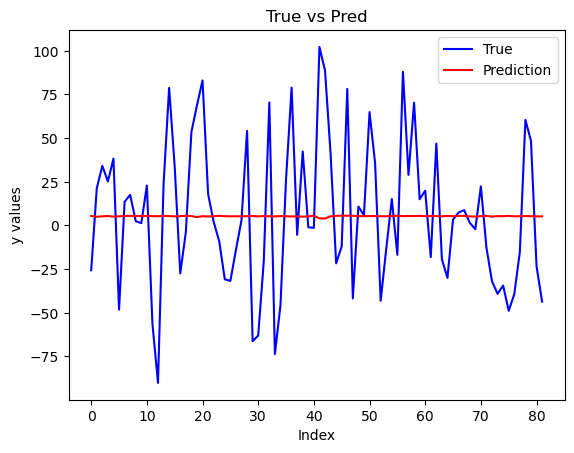

RMSE: 42.25105403741654, MAE: 34.08937568912386, R2: -0.004793125915517837
Training Iterations:  10%|█         | 1/10 [00:02<00:20,  2.28s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 51.95594054825258 , average validation RMSE is 41.50946743980121
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


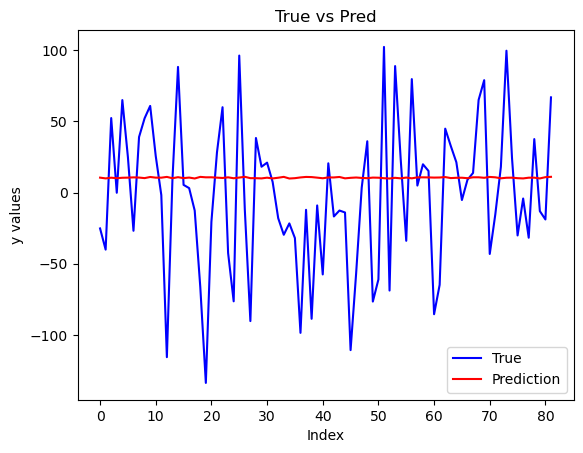

RMSE: 53.90603342165997, MAE: 42.3956938779009, R2: -0.060848319793031624
Training Iterations:  20%|██        | 2/10 [00:04<00:18,  2.30s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 47.41698544039066 , average validation RMSE is 52.0452721435512
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


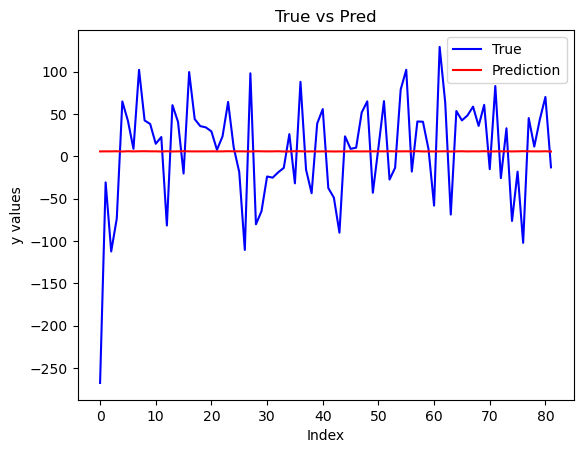

RMSE: 62.01094193976913, MAE: 48.33822210217378, R2: -0.001648692069798896
Training Iterations:  30%|███       | 3/10 [00:06<00:15,  2.25s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 52.51884104448296 , average validation RMSE is 44.705062282642025
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


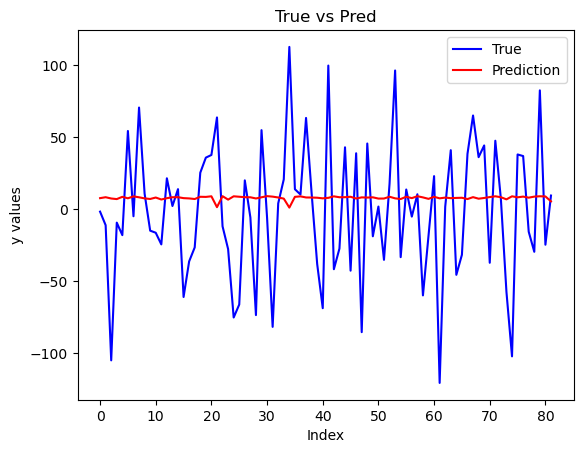

RMSE: 48.77976251022095, MAE: 38.47422029193742, R2: -0.05161157109297321
Training Iterations:  40%|████      | 4/10 [00:09<00:13,  2.30s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 53.99573882250396 , average validation RMSE is 42.06888900565815
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


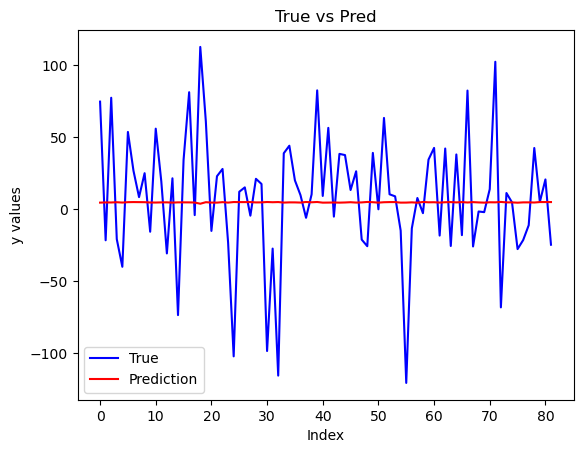

RMSE: 44.26380289834248, MAE: 32.98539322853024, R2: -0.00868049892476086
Training Iterations:  50%|█████     | 5/10 [00:11<00:11,  2.32s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 55.16380983100921 , average validation RMSE is 49.28624614539238
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


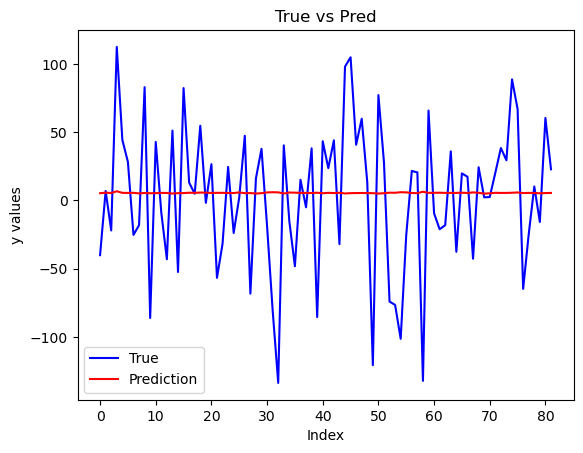

RMSE: 53.46454969473979, MAE: 42.361078094906034, R2: -0.006129341507605579
Training Iterations:  60%|██████    | 6/10 [00:14<00:09,  2.42s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 47.315041275079544 , average validation RMSE is 54.601834495253875
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


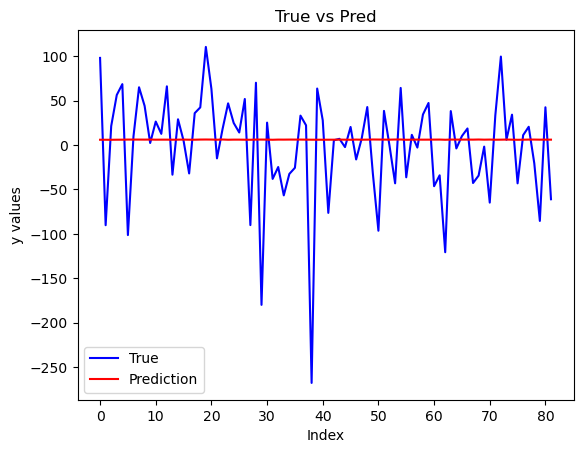

RMSE: 60.264547770423846, MAE: 43.00583660124187, R2: -0.01500433856319372
Training Iterations:  70%|███████   | 7/10 [00:16<00:07,  2.41s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 47.2170934536058 , average validation RMSE is 52.99719863880371
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


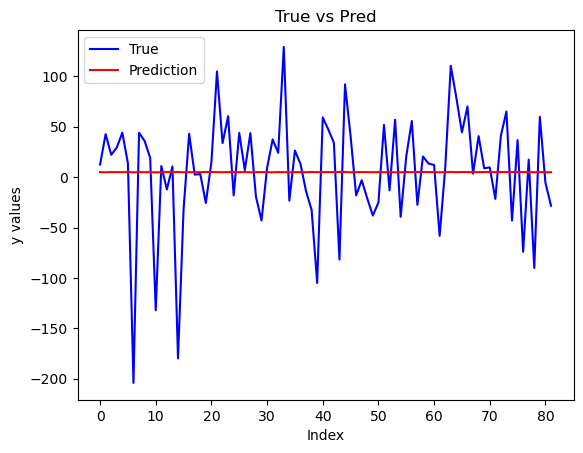

RMSE: 55.63293594695581, MAE: 40.29836680919055, R2: -0.0005882462973885172
Training Iterations:  80%|████████  | 8/10 [00:18<00:04,  2.38s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 53.852972975125816 , average validation RMSE is 40.110759836689965
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


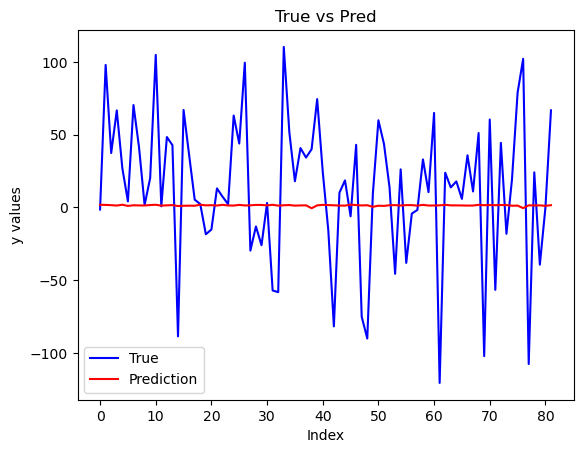

RMSE: 51.03652265515097, MAE: 39.7931190746762, R2: -0.058029064898700744
Training Iterations:  90%|█████████ | 9/10 [00:21<00:02,  2.42s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 52.44468122901956 , average validation RMSE is 42.46232337979092
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


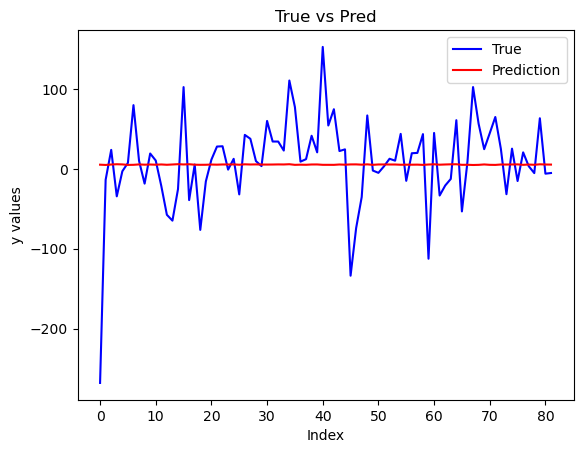

RMSE: 55.56073001017839, MAE: 37.4813883360397, R2: -0.004426143771686597
Training Iterations: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]
 
 
The average test RMSE over 10 iterations for MEF monthly data is: 52.71708808848579
 
 


In [83]:
# Test the performance of the model on 10 different random train-test splits of MEF monthly data, and report the average RMSE.
list_RMSE_train_train2=[]
list_RMSE_train_val2=[]
list_RMSE2=[]

np.random.seed(11)
random.seed(11)
tf.random.set_seed(11)

# Use tqdm for the outer loop to track progress of iterations
for i in tqdm(range(10), desc="Training Iterations", file=sys.stdout):
    # Generate training and test data sets
    X_train, y_train, X_test, y_test = split_data(X_mef_m, y_mkt_m, 0.2, i)

    # Use X_train and y_train as MAI features and target variable
    trained_model, training_history, avg_RMSE_train, avg_RMSE_test = train_neural_network_MEF(X_train, y_train)
    print('During training of this NN model, average training RMSE is', avg_RMSE_train, ', average validation RMSE is', avg_RMSE_test)
    list_RMSE_train_train2.append(avg_RMSE_train)
    list_RMSE_train_val2.append(avg_RMSE_test)

    # Have the performance of the trained model evaluated on the test set
    MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
    print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')
    list_RMSE2.append(MSE**(1/2))
avg_RMSE2=np.mean(list_RMSE2)
print(' ')
print(' ')
print('The average test RMSE over 10 iterations for MEF monthly data is:', avg_RMSE2)
print(' ')
print(' ')

Text(0.5, 1.0, 'Distribution of RMSE over Iterations (MEF monthly training data)')

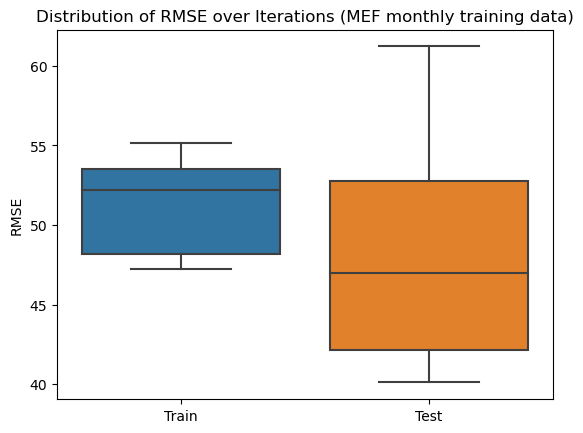

In [84]:
sns.boxplot(data=[list_RMSE_train_train2, list_RMSE_train_val2])
plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('RMSE')
plt.title('Distribution of RMSE over Iterations (MEF monthly training data)')

## Neural Networks with daily data

Now we will train again using the daily datasets. Since the size of them seems sufficient enough for getting robust results from the training of the networks, we will do only do one training.

We start with the MAI daily dataset.

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Progress: 100%|██████████ 10/10
During training of this NN model, average training RMSE is 54.76407051863521 , average validation RMSE is 53.197426123921375
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


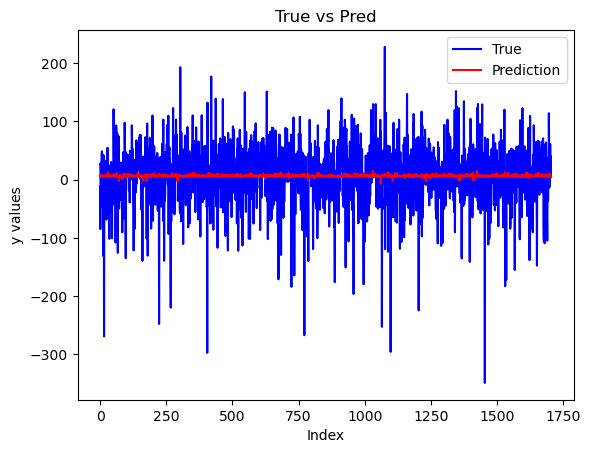

RMSE: 54.063339604724895, MAE: 39.38272566071174, R2: 0.002031989191954242
 
 
The test RMSE for MAI daily data is: 54.063339604724895
 
 


In [85]:
list_RMSE_train_val1=[]
list_RMSE1=[]
num_iterations = 1
np.random.seed(11)
random.seed(11)
tf.random.set_seed(11)

for i in range(0,num_iterations):
  # Generate training and test data sets
  X_train, y_train, X_test, y_test = split_data(X_mai_d, y_mkt_d, 0.2, i)

  # Use X_train and y_train as MAI features and target variable
  trained_model, training_history, avg_RMSE_train, avg_RMSE_test = train_neural_network_MAI(X_train, y_train)
  print('During training of this NN model, average training RMSE is', avg_RMSE_train, ', average validation RMSE is', avg_RMSE_test)
  list_RMSE_train_train1.append(avg_RMSE_train)
  list_RMSE_train_val1.append(avg_RMSE_test)

  # Have the performance of the trained model evaluated on the test set
  MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
  print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')
  list_RMSE1.append(MSE**(1/2))
avg_RMSE1=np.mean(list_RMSE1)
print(' ')
print(' ')
print('The test RMSE for MAI daily data is:', avg_RMSE1)
print(' ')
print(' ')

Now we do the same for the MEF daily data.

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Progress: 100%|██████████ 10/10
During training of this NN model, average training RMSE is 54.82926775060842 , average validation RMSE is 53.349743463172274
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


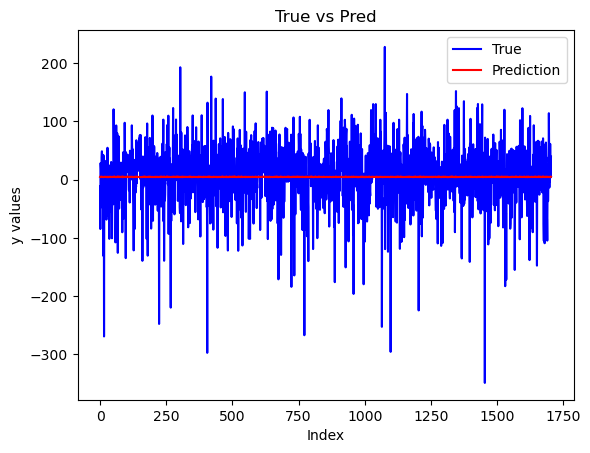

RMSE: 54.14273817913175, MAE: 39.59797940841517, R2: -0.0009014375142213371
 
 
The test RMSE for MEF daily data is: 54.14273817913175
 
 


In [92]:
# Test the performance of the model on 10 different random train-test splits of MEF daily data, and report the average RMSE.
list_RMSE_train_train3=[]
list_RMSE_train_val3=[]
list_RMSE3=[]
num_iterations = 1
np.random.seed(11)
random.seed(11)
tf.random.set_seed(11)

for i in range(0,num_iterations):
  # Generate training and test data sets
  X_train, y_train, X_test, y_test = split_data(X_mef_d, y_mkt_d, 0.2, i)

  # Use X_train and y_train as MAI features and target variable
  trained_model, training_history, avg_RMSE_train, avg_RMSE_test = train_neural_network_MEF(X_train, y_train)
  print('During training of this NN model, average training RMSE is', avg_RMSE_train, ', average validation RMSE is', avg_RMSE_test)
  list_RMSE_train_train3.append(avg_RMSE_train)
  list_RMSE_train_val3.append(avg_RMSE_test)

  # Have the performance of the trained model evaluated on the test set
  MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
  print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')
  list_RMSE3.append(MSE**(1/2))
avg_RMSE3=np.mean(list_RMSE3)
print(' ')
print(' ')
print('The test RMSE for MEF daily data is:', avg_RMSE3)
print(' ')
print(' ')